# Optimasi Portofolio dengan NSGA-II


In [1]:
%load_ext autoreload
%autoreload 2

## **A. Pengumpulan Dataset**
Dataset pada penelitian ini diperoleh melalui Yahoo Finance menggunakan library yfinance. Tujuannya adalah menyediakan data harga historis yang bersih dan konsisten untuk keperluan optimisasi portofolio.

### 1. Pemilihan Saham (LQ45)
Penelitian menggunakan 15 saham dari indeks LQ45 karena:
- Likuiditas tinggi
- Kapitalisasi besar
- Stabil untuk dianalisis
- Mewakili sektor yang beragam

Emiten yang digunakan antara lain: perbankan (BBCA, BBRI, BMRI, BBNI), telekomunikasi (TLKM), industri dasar, energi, consumer goods, dan lainnya.

### 2. Periode Penelitian
Rentang waktu yang digunakan adalah 1 November 2022 sampai 1 November 2025. Periode ini dipilih karena:
- memberikan cakupan historis yang cukup panjang untuk menangkap perubahan tren dan volatilitas,
- mencakup fase pemulihan ekonomi pascapandemi, fluktuasi komoditas, serta dinamika pasar global,
- bersifat fixed, sehingga hasil penelitian dapat direplikasi secara konsisten.

### 3. Sifat Data yang Diambil
Data yang digunakan adalah harga penutupan harian yang sudah disesuaikan (adjusted close). Data ini dianggap lebih representatif untuk analisis risiko-return karena telah memperhitungkan aksi korporasi seperti:

- stock split,
- dividen,
- maupun penyesuaian teknis lainnya.

Dengan cara ini, pola pergerakan harga yang dianalisis lebih stabil dan tidak bias terhadap perubahan struktural.

### 4. Pertimbangan Kualitas Data
Dalam pengumpulan dataset, beberapa hal juga diperhatikan:

- Likuiditas: saham yang terlalu sering tidak diperdagangkan berpotensi menghasilkan noise atau missing values.
- Kebersihan data: adanya hari libur atau suspensi perdagangan membuat beberapa data perlu dibersihkan agar time series tetap konsisten.
- Stabilitas return: dataset yang bersih membantu memastikan bahwa hasil optimisasi tidak bias akibat outlier teknis.

In [2]:
from src.dataset import download_data, process_data
import datetime

# 15 well-known ticker from LQ45
tickers = [
    'BBCA.JK', # Bank Central Asia
    'BBRI.JK', # Bank Rakyat Indonesia
    'BMRI.JK', # Bank Mandiri
    'BBNI.JK', # Bank Negara Indonesia
    'TLKM.JK', # Telkom Indonesia
    'ASII.JK', # Astra International
    'BYAN.JK', # Bayan Resources
    'TPIA.JK', # Chandra Asri
    'AMRT.JK', # Sumber Alfaria Trijaya
    'GOTO.JK', # GoTo Gojek Tokopedia
    'MDKA.JK', # Merdeka Copper Gold
    'ADRO.JK', # Adaro Energy
    'ICBP.JK', # Indofood CBP
    'UNVR.JK', # Unilever Indonesia
    'KLBF.JK'  # Kalbe Farma
]

# Take 3years ago to today
start_date = datetime.date(2022, 11, 1)
end_date = datetime.date(2025, 11, 1)

# Dataset
df = download_data(tickers, start_date, end_date)
r_matrix, mu_vector = process_data(df)

========== Downloading Data ==========


[*********************100%***********************]  15 of 15 completed

Successfully download and cleaning data!
========== End ==========
========== Processing Data ==========
----- Vector expected return (mu): -----
Ticker
ADRO.JK    0.000688
AMRT.JK   -0.000082
ASII.JK    0.000484
BBCA.JK    0.000192
BBNI.JK    0.000350
BBRI.JK    0.000251
BMRI.JK    0.000369
BYAN.JK    0.001724
GOTO.JK   -0.000871
ICBP.JK    0.000087
KLBF.JK   -0.000290
MDKA.JK   -0.000080
TLKM.JK    0.000037
TPIA.JK    0.002264
UNVR.JK   -0.000257
----- Matrix return history: -----
Ticker       ADRO.JK   AMRT.JK   ASII.JK   BBCA.JK   BBNI.JK   BBRI.JK  \
Date                                                                     
2022-11-03  0.002674 -0.007547 -0.007782  0.005714  0.005405  0.008677   
2022-11-04  0.000000  0.000000  0.007843 -0.002841 -0.002688  0.000000   

Ticker       BMRI.JK   BYAN.JK   GOTO.JK   ICBP.JK   KLBF.JK   MDKA.JK  \
Date                                                                     
2022-11-03  0.009926  0.003787  0.025641 -0.005208  0.000000 -0.020

## **B. Optimasi dengan NSGA-II**
### 1. Formulasi Masalah (Multi-Objektif)

Setelah data historis diolah, masalah optimisasi portofolio didefinisikan sebagai Multi-Objective Problem (MOP). Tujuan utama adalah mencari trade-off terbaik di antara dua objektif yang saling bertentangan:

- Objektif $f_1$ (Return): Maksimasi Expected Return Portofolio (Mean).

Ini merepresentasikan potensi keuntungan investasi. - Objektif $f_2$ (Risiko): Minimasi Conditional Value at Risk (CVaR).
Kami fokus pada CVaR karena efektivitasnya dalam menangkap kerugian ekstrem (tail risk), yang merupakan risiko paling relevan bagi investor di dunia nyata.

Batasan Utama (Constraints):
Solusi bobot portofolio ($\mathbf{w}$) harus mematuhi:
- Bobot total harus 100% ($\sum w_i = 1$).
- Tidak ada short selling ($w_i \ge 0$).
- Bobot maksimum per aset dibatasi 30% ($w_i \le 0.3$) untuk menjamin diversifikasi.

### 2. Penentuan Parameter dan Algoritma

Digunakan NSGA-II karena efisien dan terbukti robust untuk masalah optimisasi 2-objektif. Parameter yang digunakan dipilih berdasarkan baseline yang teruji di literatur, sesuai dengan batasan penelitian (tidak melakukan tuning parameter mendalam).

Parameter NSGA-II: (1) Ukuran Populasi: 100, (2) Jumlah Generasi: 200.
Operator Evolusi: Menggunakan Simulated Binary Crossover (SBX) dan Polynomial Mutation (PM), standar untuk Algoritma Genetika real-coded.

In [3]:
n_stocks = 15           # N=15 saham
w_max = 0.3             # Batasan holding maksimum 30% per saham
n_population = 100      # Ukuran populasi
n_generations = 200     # Jumlah generasi

In [4]:
from src.optimizer import run_optimization

pf_f, pf_w = run_optimization(r_matrix, mu_vector, n_population, n_generations, n_stocks, w_max)

----- Optimisasi dengan NSGA II -----
Memulai optimisasi...

Menjalankan NSGA-II...
   Populasi: 100
   Generasi: 200
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      4 |  0.000000E+00 |  9.992007E-17 |             - |             -
     2 |      200 |      4 |  0.000000E+00 |  4.440892E-18 |  0.2015493431 |         ideal
     3 |      300 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0550422405 |         ideal
     4 |      400 |      5 |  0.000000E+00 |  0.000000E+00 |  0.2054326665 |         ideal
     5 |      500 |      8 |  0.000000E+00 |  0.000000E+00 |  0.2523001821 |         ideal
     6 |      600 |      9 |  0.000000E+00 |  0.000000E+00 |  0.0140521424 |         ideal
     7 |      700 |     11 |  0.000000E+00 |  0.000000E+00 |  0.2352575374 |         ideal
     8 |      800 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0258694612 |         ideal
     9 |      900 |     14 |  0.000000E+00 |  0.000000E+00 |  0

## **C. Visualisasi dan Analisis Hasil**

Memulai visualisasi dan analisis...

Visualisasi Pareto Front berhasil dibuat.
Plot disimpan sebagai 'pareto_front_plot.png'


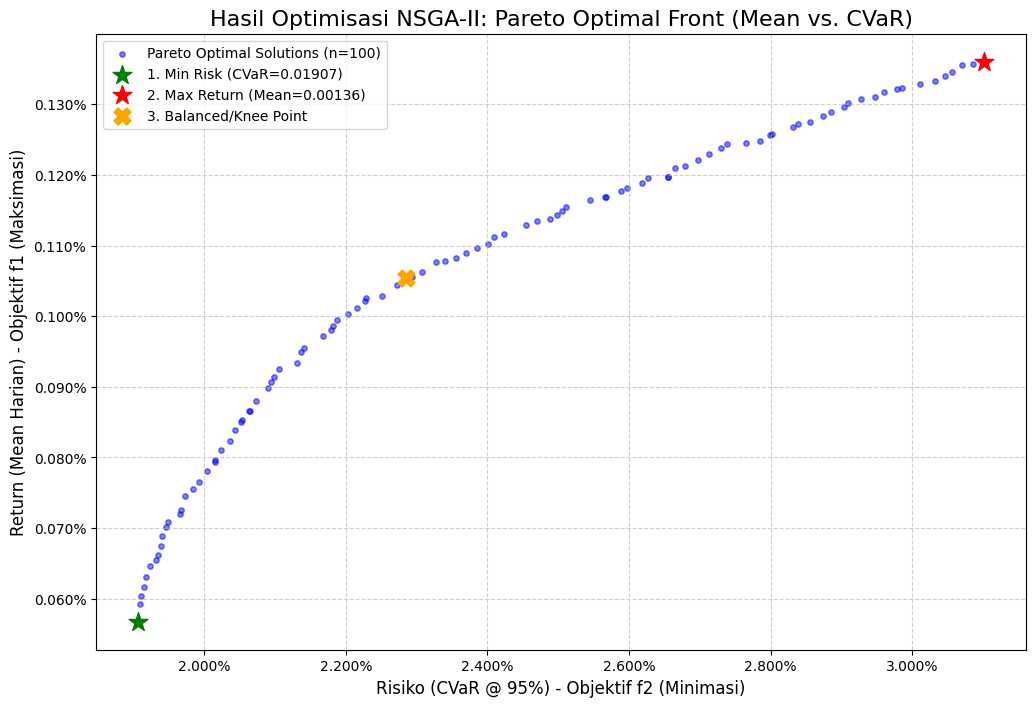


1. Portofolio Risiko Minimum (Paling Konservatif)
  > Mean Return (f1): 0.000567 (Daily)
  > CVaR Risk (f2)  : 0.019068 (Daily @ 95%)

  Komposisi Bobot (di atas 0.5%):
    - BYAN.JK : 22.87%
    - BBCA.JK : 20.63%
    - ICBP.JK : 19.37%
    - ASII.JK : 17.33%
    - KLBF.JK :  4.44%
    - ADRO.JK :  4.26%
    - BBNI.JK :  3.87%
    - MDKA.JK :  2.88%
    - UNVR.JK :  2.14%
    - BBRI.JK :  0.72%
    - TLKM.JK :  0.64%

3. Portofolio Titik Tengah (Balanced/Knee)
  > Mean Return (f1): 0.001054 (Daily)
  > CVaR Risk (f2)  : 0.022856 (Daily @ 95%)

  Komposisi Bobot (di atas 0.5%):
    - BYAN.JK : 29.74%
    - ASII.JK : 27.57%
    - TPIA.JK : 14.89%
    - ICBP.JK :  9.15%
    - BBCA.JK :  7.75%
    - BBNI.JK :  5.18%
    - ADRO.JK :  4.75%

2. Portofolio Return Maksimum (Paling Agresif)
  > Mean Return (f1): 0.001360 (Daily)
  > CVaR Risk (f2)  : 0.031012 (Daily @ 95%)

  Komposisi Bobot (di atas 0.5%):
    - BYAN.JK : 29.96%
    - TPIA.JK : 29.66%
    - ASII.JK : 25.81%
    - BBCA.JK :  

In [5]:
from src.visualize import visualize_results

tickers_list = mu_vector.index.to_list()
visualize_results(pareto_front_F=pf_f, pareto_weights_X=pf_w, tickers=tickers_list)

### 1. Analisis Kurva Optimal
Output utama dari `optimizer.py` adalah Pareto Optimal Front, yang berisi 100 portofolio non-dominan (optimal). Kurva ini merepresentasikan "menu" trade-off yang tersedia bagi investor.

Visualisasi di bawah (Gambar 1) memetakan 100 portofolio ini dalam grafik 2D:
- Sumbu-Y (Vertikal): Return (Mean Harian). Semakin tinggi, semakin baik (Maksimasi).
- Sumbu-X (Horizontal): Risiko (CVaR @ 95%). Semakin ke kiri, semakin baik (Minimasi).

Temuan Utama dari Plot:
Plot ini secara visual membuktikan trade-off yang ada. Untuk mendapatkan return harian yang lebih tinggi (bergerak ke atas dari 0.057% ke 0.136%), investor harus menerima risiko kerugian ekstrem (CVaR) yang lebih tinggi (bergerak ke kanan dari 1.907% ke 3.101%).

### 2. Interpretasi Komposisi Aset

Analisis selanjutnya berfokus pada bagaimana komposisi bobot ($\mathbf{w}$) berubah di antara ketiga portofolio kunci tersebut. Hasil ini memberikan wawasan praktis bagi investor dalam menyusun strategi alokasi aset sesuai dengan profil risiko mereka (konservatif, moderat, atau agresif).

Portofolio:
1. Min Risk
   - Return: 0.057% (Rendah)
   - Risk: 1.907% (Terendah)
   - Top 5 Holdings:
     1. BYAN.JK: 22.87% 
     2. BBCA.JK: 20.63% 
     3. ICBP.JK: 19.37% 
     4. ASII.JK: 17.33% 
     5. KLBF.JK: 4.44%
2. Balanced
   - Return: 0.105% (Tengah)
   - Risk: 2.286% (Rendah-Tengah)
   - Top 5 Holdings:
      1. BYAN.JK: 29.74% 
      2. ASII.JK: 27.57% 
      3. TPIA.JK: 14.89% 
      4. ICBP.JK: 9.15% 
      5. BBCA.JK: 7.75%
3. Max Return
   - Return: 0.136% (Tertinggi)
   - Risk: 3.101% (Tinggi)
   - Top 5 Holdings:
     1. BYAN.JK: 29.96% 
     2. TPIA.JK: 29.66% 
     3. ASII.JK: 25.81% 
     4. BBCA.JK: 6.46% 
     5. ADRO.JK: 5.04%